In [1]:
fnames = io.l1b_filenames('mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T12002', iterator=False)

In [2]:
fname = fnames[0]
fnames # checking if there's more than one version of it in stage.

['/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120029_v01_r01.fits.gz']

In [3]:
import seaborn as sns
sns.set_context('talk')
sns.set_style("white")

In [4]:
l1b = io.L1BReader(fname)

In [40]:
%matplotlib nbagg

In [41]:
plt.ion()

<IPython.core.display.Javascript object>


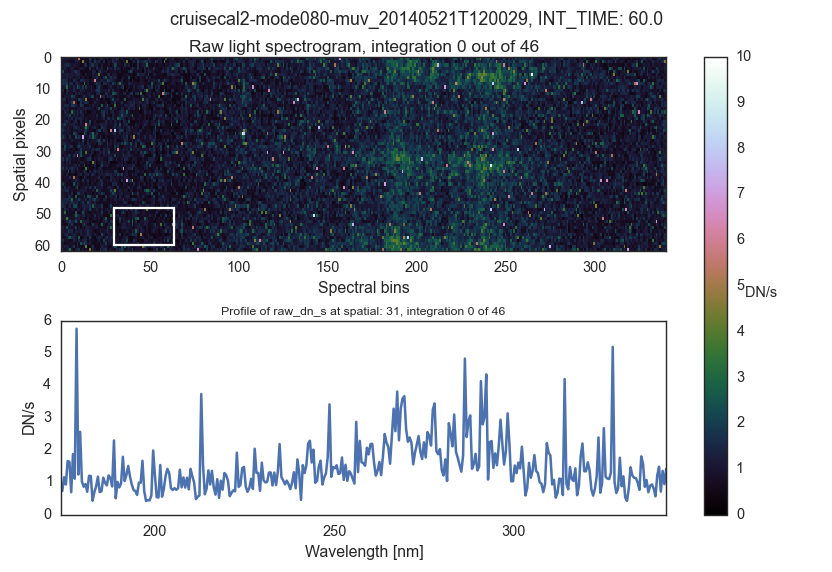

In [7]:
l1b.plot_raw_overview(0, save_token='1_int0', proflog=False, imglog=False);

<IPython.core.display.Javascript object>


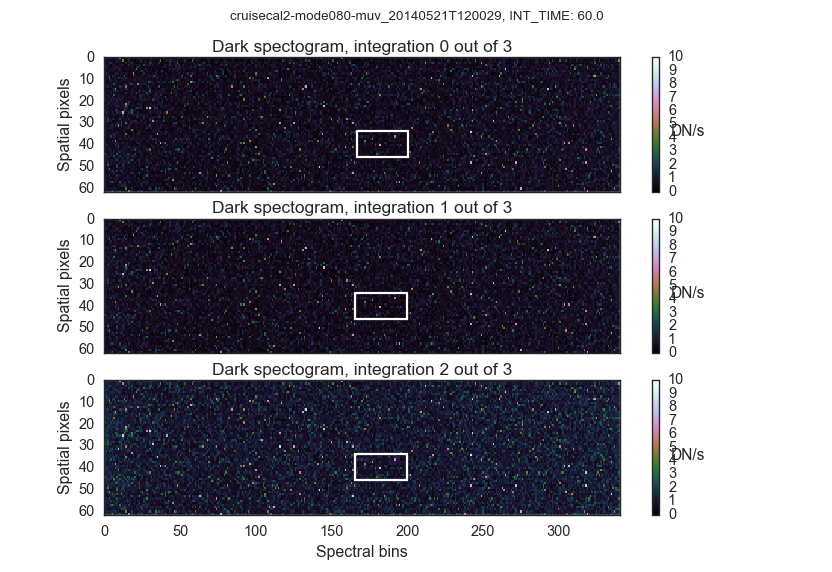

In [8]:
l1b.plot_dark_spectrograms()

<IPython.core.display.Javascript object>


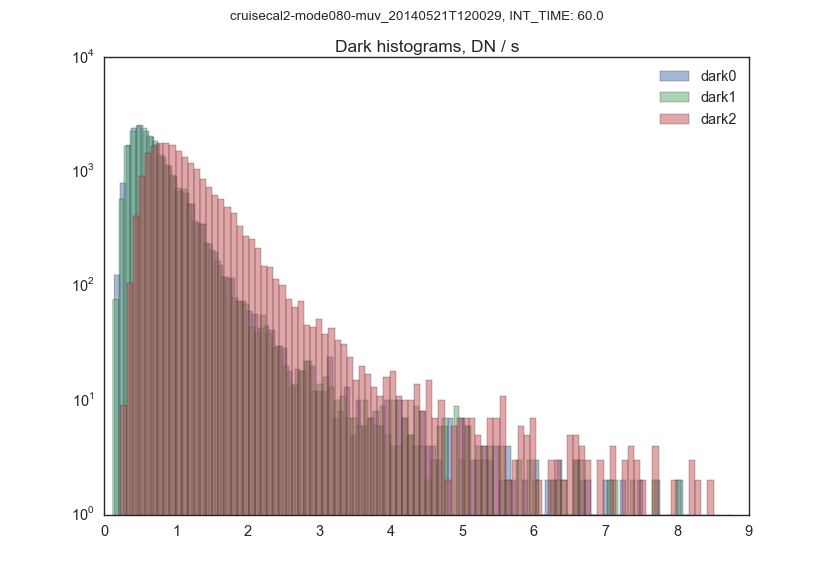

In [9]:
l1b.plot_dark_histograms(save=True)

<IPython.core.display.Javascript object>


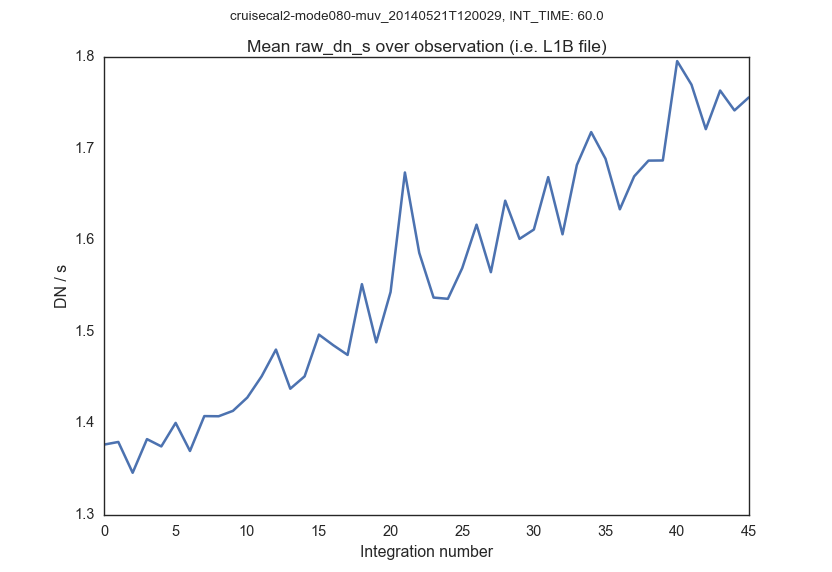

In [10]:
l1b.plot_mean_raw_values()

In [11]:
sns.set_palette('bright', 5)

In [36]:
import os
def plot_coeffs(results, ndark, token=''):
    results.index.name = 'Integrations'
    results.filter(regex='AddScaler').plot(title="Dark{} against all lights, {}".format(ndark,
                                                                                        token),
                                           ylim=[-0.5, 2])
    results['MultScaler'].plot(color=sns.color_palette()[1],
                                            ylim=[-0.5, 2],
                                            ls='--', legend=True)

    for col,ls in zip(results.filter(regex='poly1_'), ['-', '--']):
        results[col].plot(color=sns.color_palette()[2], legend=True, linestyle=ls)
    for col,ls in zip(results.filter(regex='poly2_'), ['-', '--','-.']):
        results[col].plot(color=sns.color_palette()[3], legend=True, linestyle=ls)
    savename = os.path.join(str(io.plotfolder),
                            'dark{}_vs_all_lights_'+token+'.png').format(ndark)
    plt.savefig(savename, dpi=150)    

from iuvs.multitools import *
def fit_over_integrations(endslice=None, spa_slice=None, spe_slice=None):
    all_coeffs = []
    all_residual_std = []
    # endslice just to make faster single executions possible
    for ndark in range(l1b.n_darks)[:endslice]:
        print('doing dark {}'.format(ndark))
        coeffs = []
        residual_mean = []
        residual_std = []
        current_residual_mean = []
        current_residual_std = []
        prog = IntProgress(min=0, max=l1b.n_integrations)
        display(prog)
        for nraw in range(l1b.n_integrations):
            fitter = scaling.DarkFitter(l1b, nraw, ndark, 
                                        spa_slice=spa_slice, spe_slice=spe_slice)
            coeffs.append(fitter.p_dicts)
            residual_mean.append(fitter.residual_mean)
            residual_std.append(fitter.residual_std)
            current_residual_mean.append(fitter.currentresidual.mean())
            current_residual_std.append(fitter.currentresidual.std())
            prog.value = nraw
        all_coeffs.append(pd.DataFrame(coeffs))
#         residual_mean = pd.DataFrame(residual_mean)
        residual_std = pd.DataFrame(residual_std)
#         residual_mean['current'] = current_residual_mean
        residual_std['current'] = current_residual_std
        all_residual_std.append(residual_std)
    return all_coeffs, all_residual_std

# Automatic scaling window

In [37]:
plt.close('all')

In [38]:
coeffs, res_std = fit_over_integrations()

doing dark 0
doing dark 1
doing dark 2


<IPython.core.display.Javascript object>


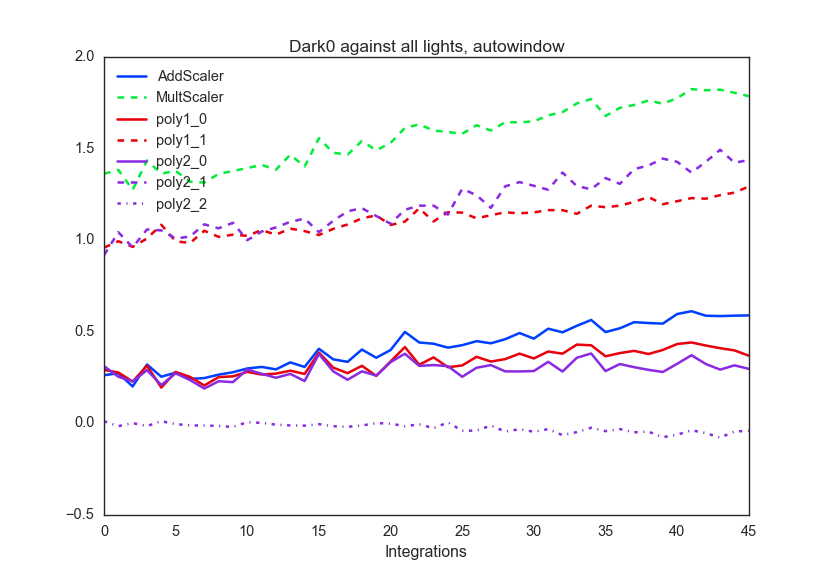

<IPython.core.display.Javascript object>


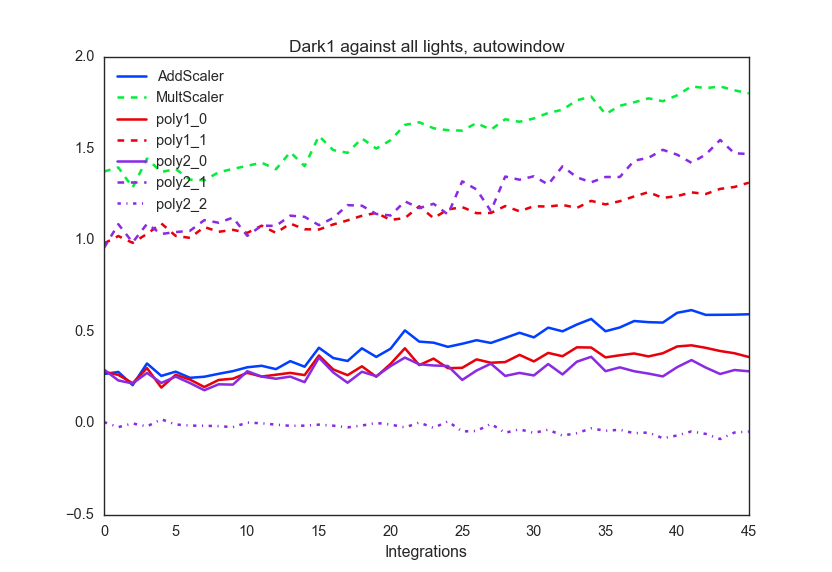

<IPython.core.display.Javascript object>


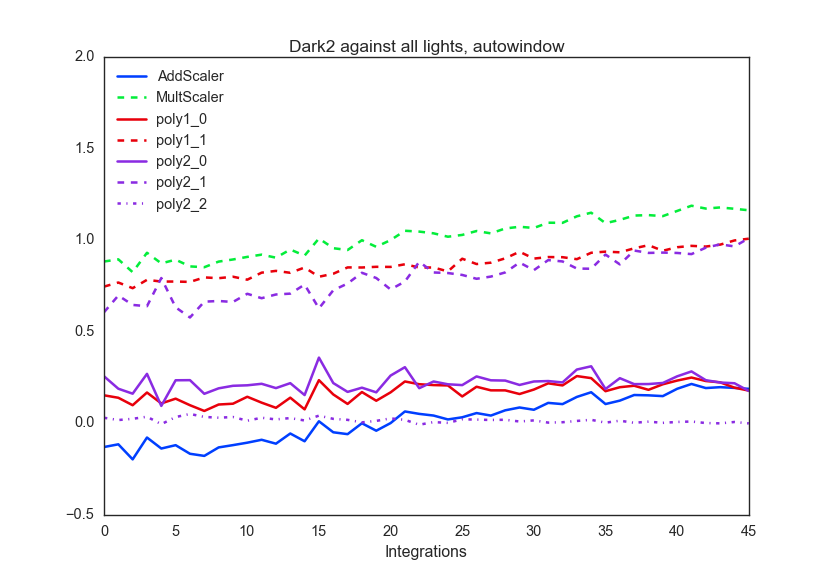

In [44]:
for j in range(3):
    plot_coeffs(coeffs[j], j, token='autowindow')

<IPython.core.display.Javascript object>


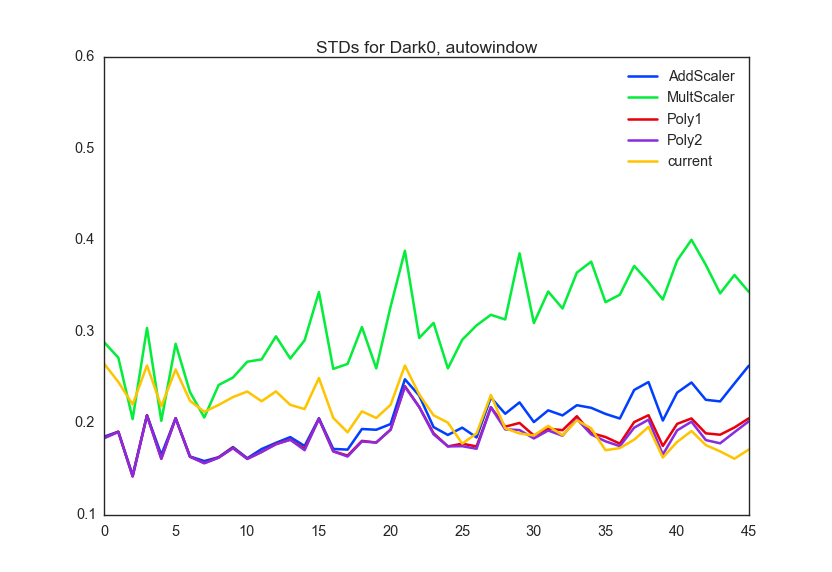

<IPython.core.display.Javascript object>


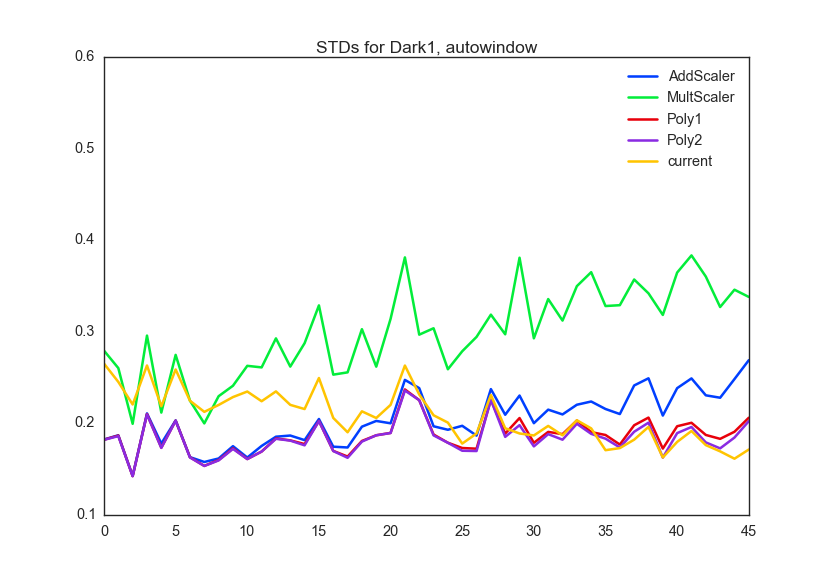

<IPython.core.display.Javascript object>


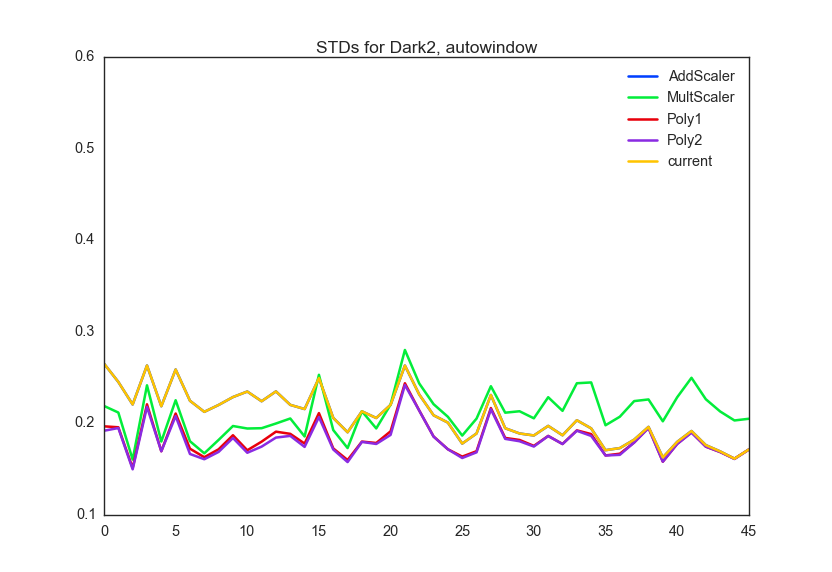

In [45]:
for j in range(3):
    res_std[j].plot(title='STDs for Dark{}, autowindow'.format(j), ylim=(0.1, 0.6))
    plt.savefig('/Users/klay6683/plots/STDs_dark{}_autowindow.png'.format(j), dpi=150)

# Fixed scaling window

In [46]:
spa_slice, spe_slice = l1b.find_scaling_window(l1b.raw_dn_s[0])

In [47]:
coeffs, res_std = fit_over_integrations(spa_slice=spa_slice, spe_slice=spe_slice)

doing dark 0
doing dark 1
doing dark 2


<IPython.core.display.Javascript object>


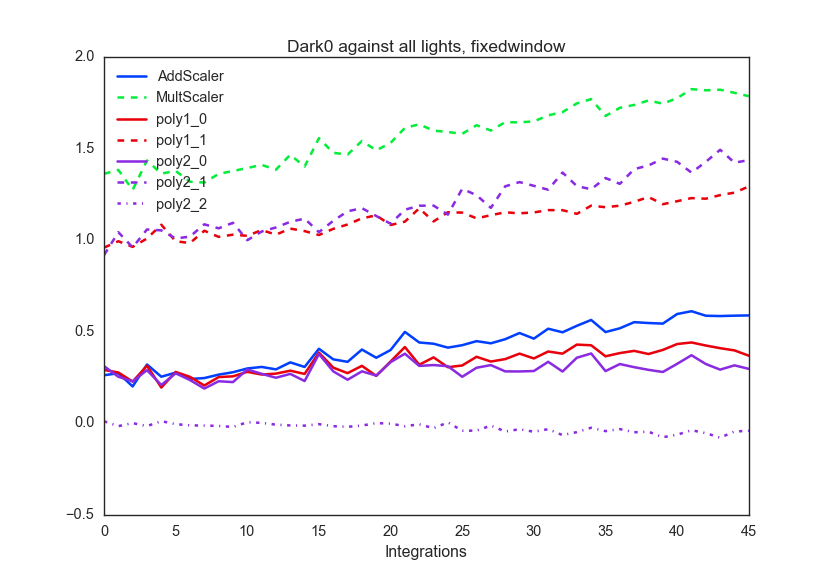

<IPython.core.display.Javascript object>


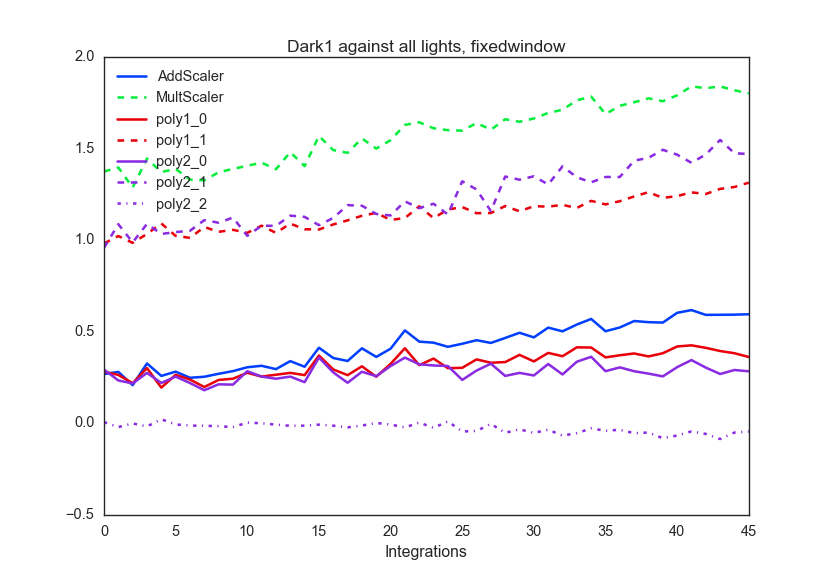

<IPython.core.display.Javascript object>


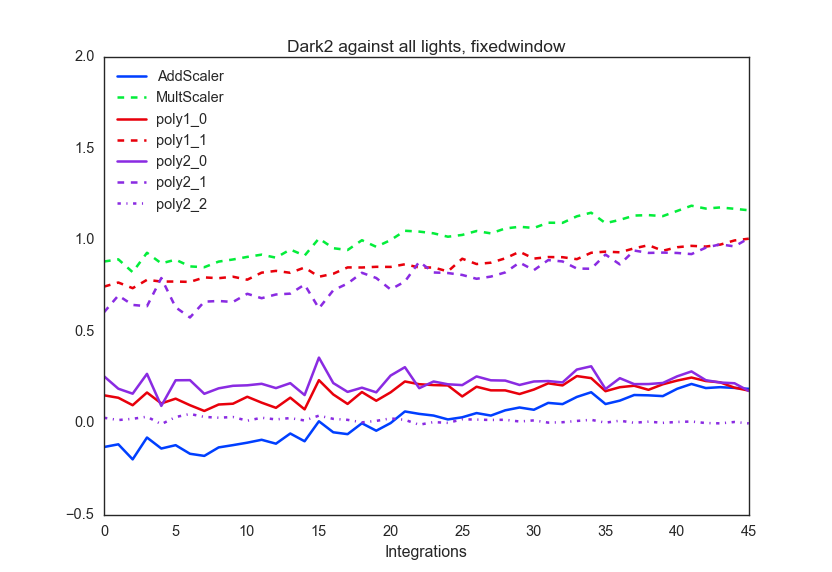

In [42]:
for j in range(3):
    plot_coeffs(coeffs[j], j, token='fixedwindow')

<IPython.core.display.Javascript object>


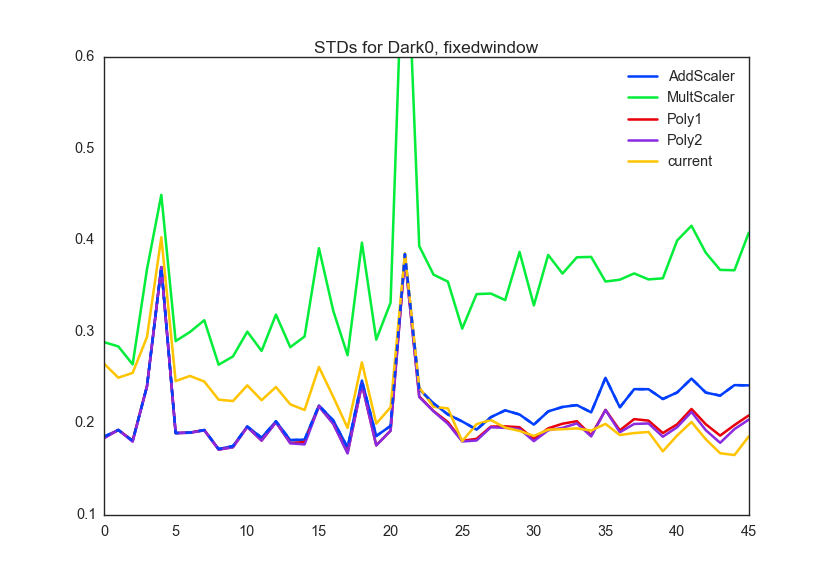

<IPython.core.display.Javascript object>


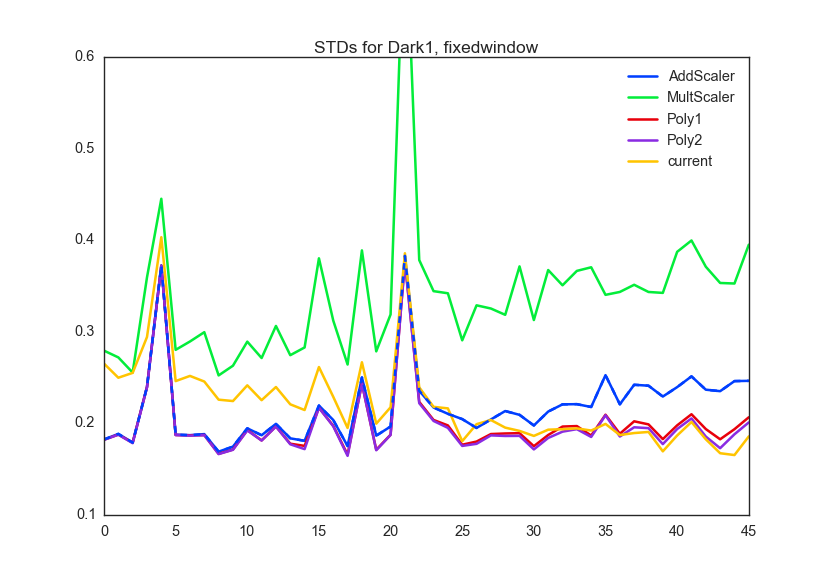

<IPython.core.display.Javascript object>


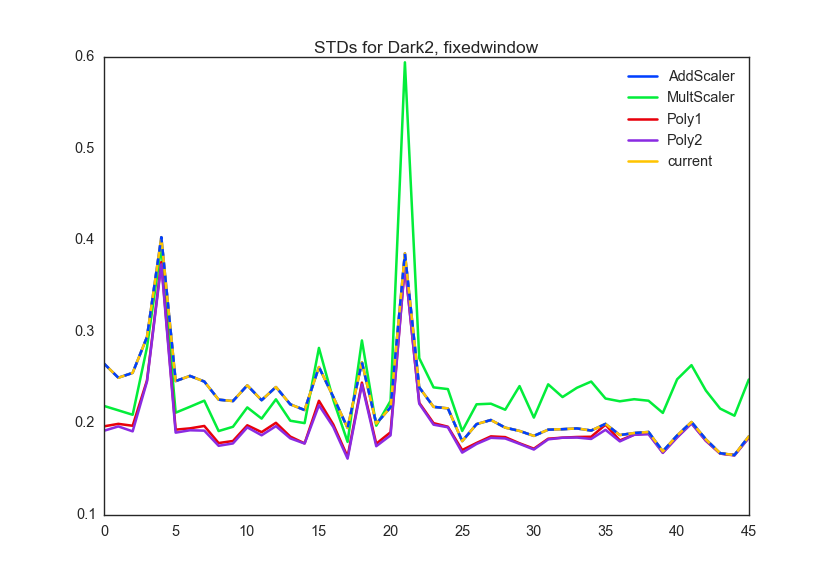

In [48]:
for j in range(3):
    res_std[j].plot(title='STDs for Dark{}, fixedwindow'.format(j), ylim=(0.1, 0.6))
    res_std[j]['AddScaler'].plot(style='--')
    plt.savefig('/Users/klay6683/plots/STDs_dark{}_fixedwindow.png'.format(j), dpi=150)

# Applying poly1 and compare with current subtraction

In [29]:
from iuvs.multitools import *

In [34]:
import os
def apply_and_compare(l1b, Scaler=scaling.PolyScaler1):
    plt.ioff()
    plt.rcParams['image.cmap']='cubehelix'
    plt.rcParams['image.interpolation'] = None
    
    # determine visual max and min for image plots
    min_, max_ = np.percentile(l1b.dds_dn_s, (1,99))
    for ndark in range(l1b.n_darks):
        prog = IntProgress(min=0, max=l1b.n_integrations)
        display(prog)
        fulldark = l1b.get_integration('dark_dn_s', ndark)
        coeffs = []
        for nraw in range(l1b.n_integrations):
            fullraw = l1b.get_integration('raw_dn_s', nraw)
            spa_slice, spe_slice = l1b.find_scaling_window(fullraw)
            raw_subframe = fullraw[spa_slice, spe_slice]
            dark_subframe = fulldark[spa_slice, spe_slice]
            scaler = Scaler(dark_subframe, raw_subframe)
            scaler.do_fit()
            newdark = scaler.apply_fit(fulldark)
            subtracted = fullraw - newdark
            current = l1b.get_integration('dds_dn_s', nraw)

            
#             # plotting
#             fig, ax = plt.subplots(nrows=3)
#             rawmin, rawmax = np.percentile(fullraw, (1,99))
#             ax[0].imshow(fullraw, vmin=rawmin, vmax=rawmax)
#             ax[0].set_title('Raw, {}_{} (NOT same colormap!)'.format(ndark, nraw))
#             ax[1].imshow(current, vmin=min_, vmax=max_)
#             ax[1].set_title('Current dark subtraction')
#             im = ax[2].imshow(subtracted, vmin=min_, vmax=max_)
#             ax[2].set_title("{} scaled dark subtracted".format(Scaler))
#             ax[2].set_xlabel('Spectral pixel number')
#             fig.tight_layout()
#             fig.subplots_adjust(top=0.9, bottom=0.1)
#             cb = plt.colorbar(im, ax=ax.ravel().tolist())
#             cb.set_label('  DN/s', fontsize=13, rotation=0)
#             fig.savefig(os.path.join(str(io.plotfolder),
#                                      'compare_{}_{}.png'.format(ndark, str(nraw).zfill(2))),
#                         dpi=120)
#             plt.close(fig)
            with sns.axes_style('whitegrid'):
                fig, ax = plt.subplots(nrows=3, sharex=True)
                for row, myaxis in zip([5,31,55], ax):
                    for data, style,name in zip([fullraw, current, subtracted],
                                                ['b-','r-','g-'],
                                                ['Raw', 'Current', 'ScaledDark']):
                        myaxis.plot(data[row], style, label='{}, row{}'.format(name, row),
                                    lw=1, alpha=0.7)
                    myaxis.set_ylim(-0.5, 4)
                    myaxis.legend()
                    myaxis.set_ylabel('DN / s')
                    myaxis.set_title('Row {}, {}'.format(row, scaler.p_formatted),
                                     fontsize=10)
                ax[2].set_xlabel('Spectral pixel number')
                fig.suptitle('Profile comparison, dark{}'.format(ndark))
                fig.savefig(os.path.join(str(io.plotfolder),
                                         'mean_profs_compare_{}_{}.png'.format(ndark, str(nraw).zfill(2))),
                           dpi=120)
                plt.close(fig)
            prog.value = nraw+1

In [35]:
apply_and_compare(l1b)

# Checking relationship between darks

In [37]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


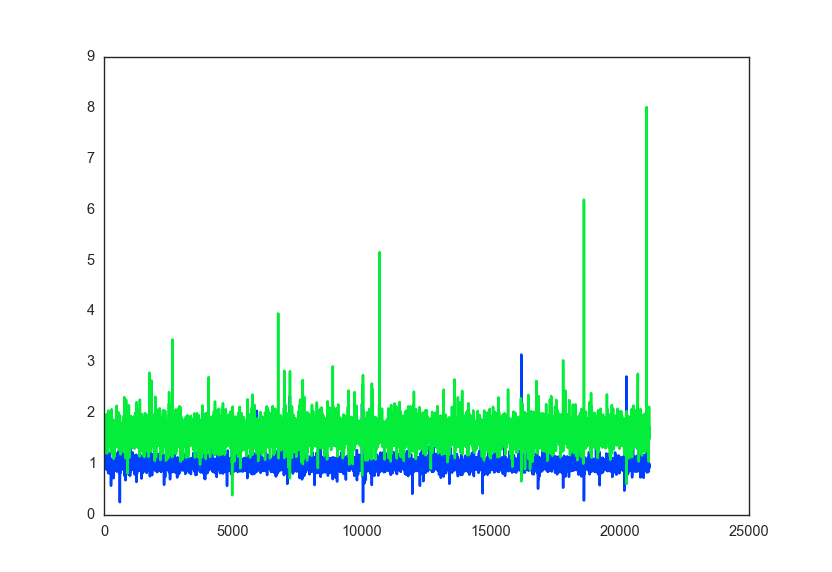

In [13]:
plt.figure()
plt.plot(l1b.dark_dn_s[1].ravel()/l1b.dark_dn_s[0].ravel())
plt.plot(l1b.dark_dn_s[2].ravel()/l1b.dark_dn_s[1].ravel())

In [14]:
from scipy import stats
from sklearn import preprocessing

In [15]:
dark0 = preprocessing.normalize(l1b.dark_dn_s[0])
dark1 = preprocessing.normalize(l1b.dark_dn_s[1])
dark2 = preprocessing.normalize(l1b.dark_dn_s[2])

In [16]:
stats.pearsonr(dark0.ravel(), dark1.ravel())

(0.99669152818151741, 0.0)

In [17]:
stats.pearsonr(dark1.ravel(), dark2.ravel())

(0.98634744649404338, 0.0)

<IPython.core.display.Javascript object>


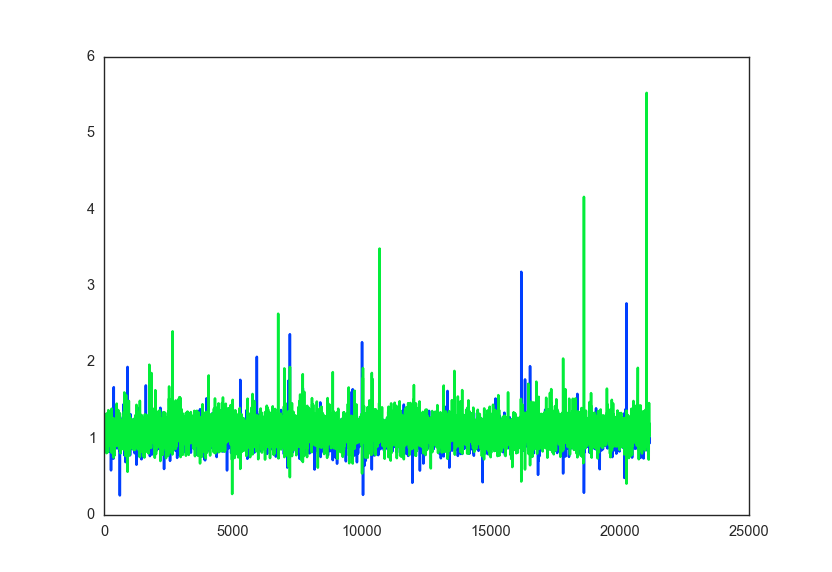

In [18]:
plt.figure()
plt.plot(dark1.ravel()/dark0.ravel())
plt.plot(dark2.ravel()/dark1.ravel())

<IPython.core.display.Javascript object>


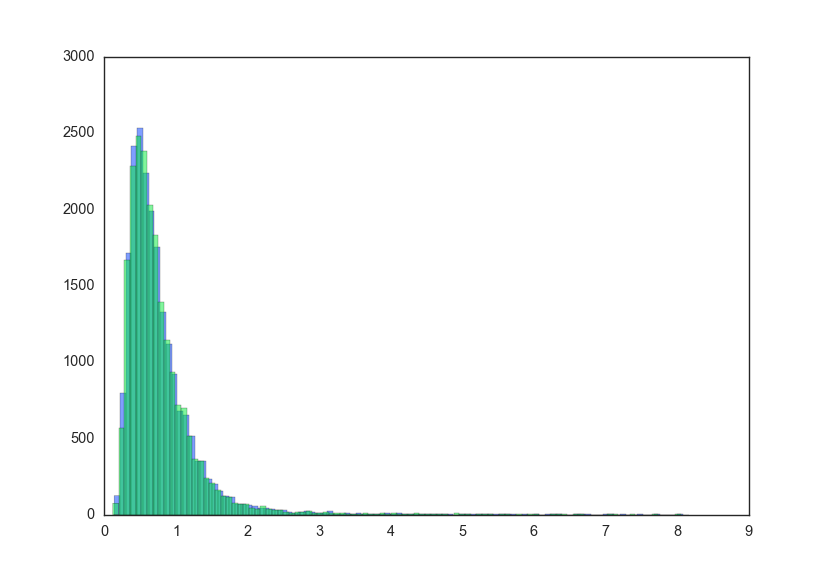

In [19]:
plt.figure()
plt.hist(l1b.dark_dn_s[0].ravel(), 100, alpha=0.5)
plt.hist(l1b.dark_dn_s[1].ravel(), 100, alpha=0.5);

In [20]:
from scipy.stats import gaussian_kde

In [21]:
density0 = gaussian_kde(l1b.dark_dn_s[0].ravel())
density1 = gaussian_kde(l1b.dark_dn_s[1].ravel())
density2 = gaussian_kde(l1b.dark_dn_s[2].ravel())

In [22]:
x = np.linspace(0, 5, 400)

<IPython.core.display.Javascript object>


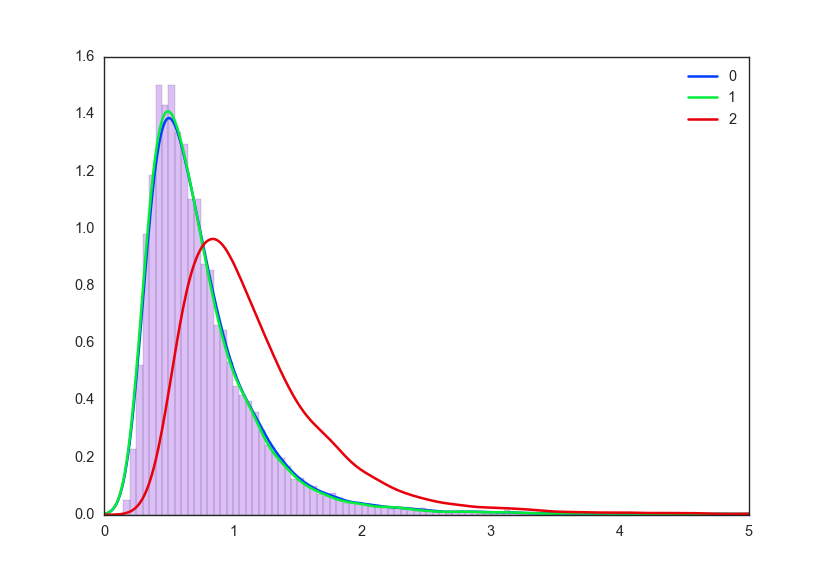

In [23]:
plt.figure()
plt.plot(x, density0(x), label='0')
plt.plot(x, density1(x), label='1')
plt.plot(x, density2(x), label='2')
plt.hist(l1b.dark_dn_s[0].ravel(), 100, alpha=0.3, normed=True, range=(0,5))
plt.legend()

# Interpolating between darks

## Using mean value of frames

In [24]:
x = l1b.DarkIntegration.ET.values[1:]

In [25]:
y = l1b.dark_dn_s.mean(axis=(1,2))[1:]

In [26]:
y

array([ 0.78085264,  1.21756524])

In [71]:
from scipy import polyfit, poly1d

In [72]:
fit = poly1d(polyfit(x, y, 1))

In [74]:
new_y = fit(l1b.Integration.ET.values)

<IPython.core.display.Javascript object>


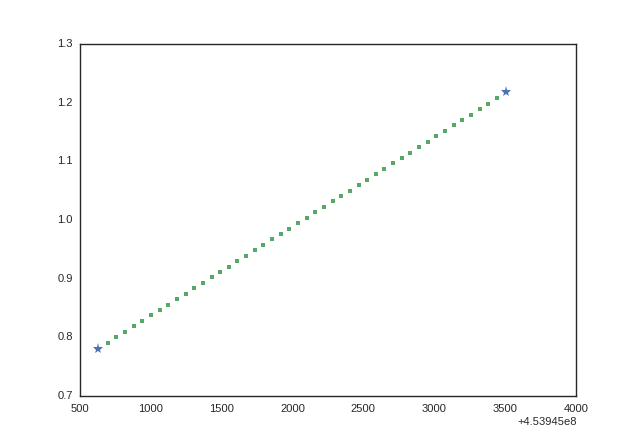

In [77]:
plt.figure()
plt.plot(x, y, '*', ms=10)
plt.plot(l1b.Integration.ET.values, new_y, '.', ms=8)

In [80]:
plt.close('all')

In [86]:
factor = l1b.dark_dn_s[2].mean()/l1b.dark_dn_s[1].mean()

<IPython.core.display.Javascript object>


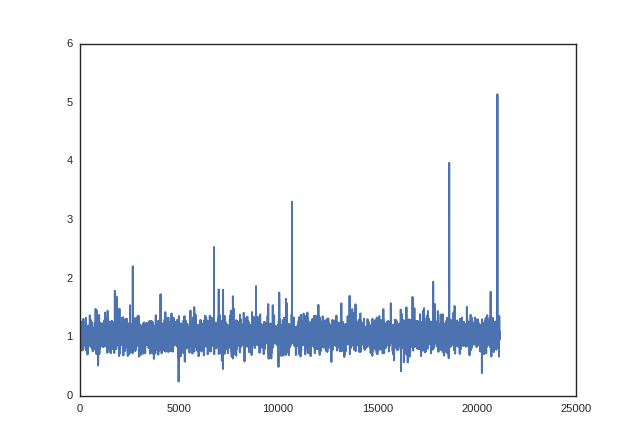

In [90]:
plt.figure()
plt.plot(l1b.dark_dn_s[2].ravel()/(factor*l1b.dark_dn_s[1].ravel()))